In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response


In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

In [4]:
"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA GeForce RTX 3090'


## *relu*

Target: 
$$
y = ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$ 

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

### training

In [8]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

#### n_feat=2, n_hidden=1

In [20]:
layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

relu_cis = Cis(simple_relu_cfg, device="cpu")

batch_sz = 1024
feat_sparsity = 0
feat_importance = 1
n_steps = 3000
logging_freq = n_steps // 100
optimizer = t.optim.Adam(relu_cis.parameters())

losses = train(
    relu_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/3000 [00:00<?, ?it/s]

[0.16562409698963165,
 0.17193859815597534,
 0.1438383311033249,
 0.1463208794593811,
 0.14387011528015137,
 0.12220650911331177,
 0.12103700637817383,
 0.12610559165477753,
 0.12637022137641907,
 0.1112046092748642,
 0.10929231345653534,
 0.1107584536075592,
 0.10807585716247559,
 0.10346116870641708,
 0.0955846831202507,
 0.09679735451936722,
 0.09485233575105667,
 0.09156833589076996,
 0.09830975532531738,
 0.09579167515039444,
 0.08261888474225998,
 0.08699773252010345,
 0.08427412807941437,
 0.09070920944213867,
 0.08421659469604492,
 0.08608466386795044,
 0.08110610395669937,
 0.07525833696126938,
 0.07879246771335602,
 0.08858004212379456,
 0.08466271311044693,
 0.07567581534385681,
 0.0756201520562172,
 0.07800254970788956,
 0.07465588301420212,
 0.07855860888957977,
 0.07447549700737,
 0.07113583385944366,
 0.0699881762266159,
 0.07061411440372467,
 0.06810541450977325,
 0.07770898193120956,
 0.06921553611755371,
 0.07425478845834732,
 0.07324519008398056,
 0.07692571729421616

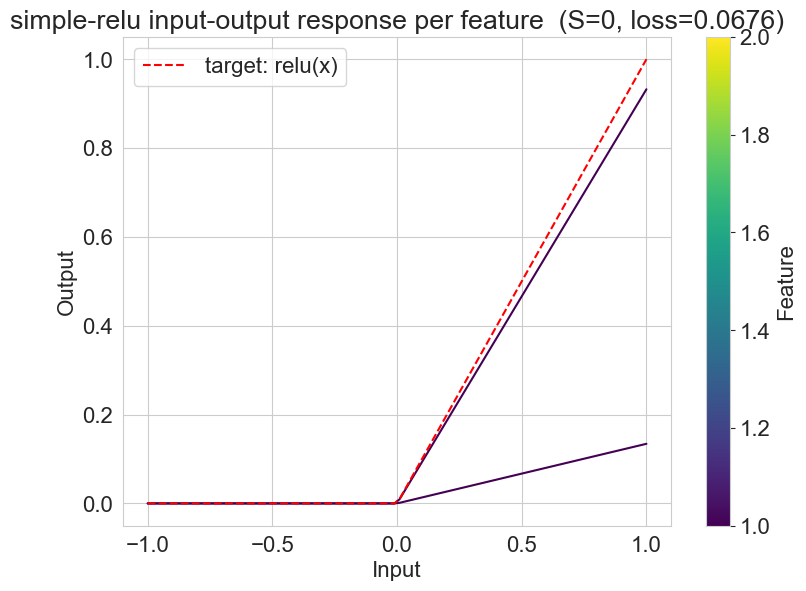

In [21]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"simple-relu input-output response per feature  (S={feat_sparsity}, loss={losses[-1]:.4f})")
ax.legend()

W.shape=torch.Size([1, 2])


Text(0.5, 1.0, 'simple-relu feature weights per neuron')

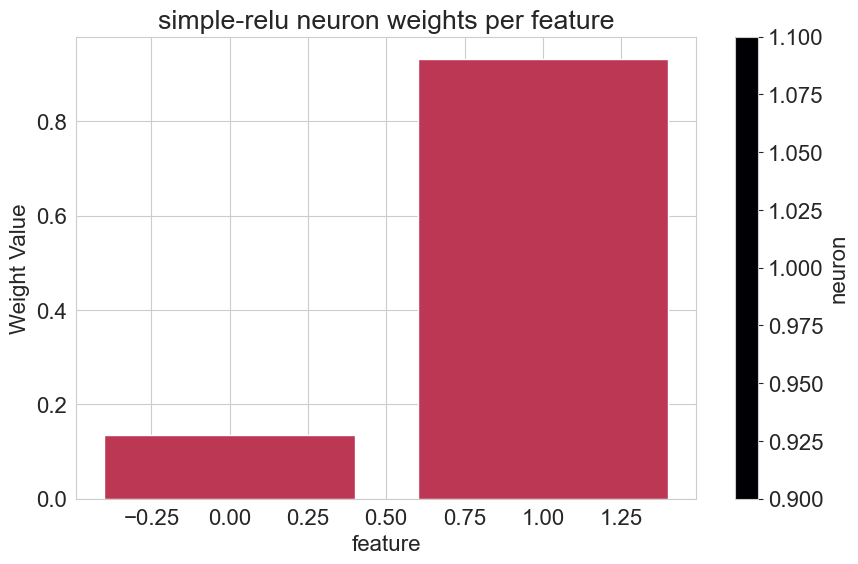

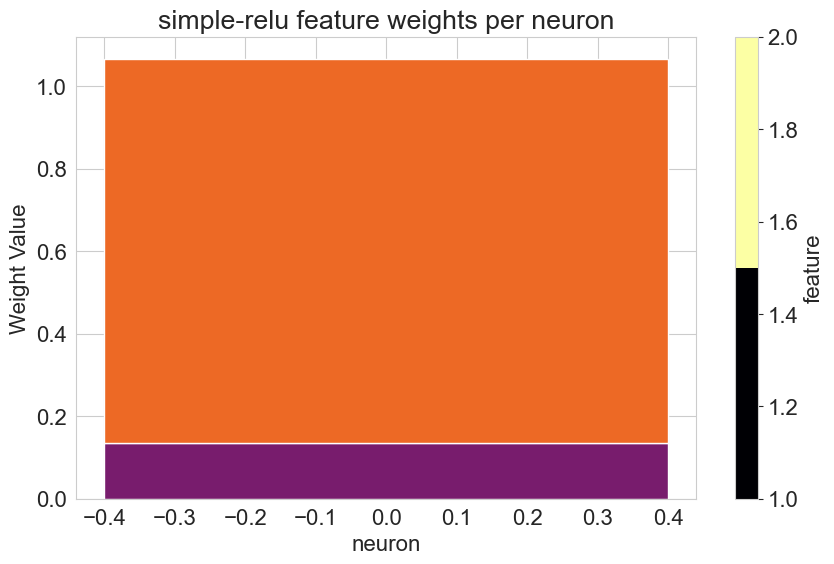

In [22]:
W = einsum(relu_cis.W1, relu_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("simple-relu neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("simple-relu feature weights per neuron")

#### n_feat=100, n_hidden=50

In [36]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

relu_cis = Cis(simple_relu_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(relu_cis.parameters())

losses = train(
    relu_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.0017452597385272384,
 0.0010482494253665209,
 0.0008425994892604649,
 0.0010213933419436216,
 0.0009893106762319803,
 0.001114419661462307,
 0.0009016505791805685,
 0.0009106894722208381,
 0.0008889485034160316,
 0.0008294851868413389,
 0.0006587081588804722]

### viz

#### input-output response

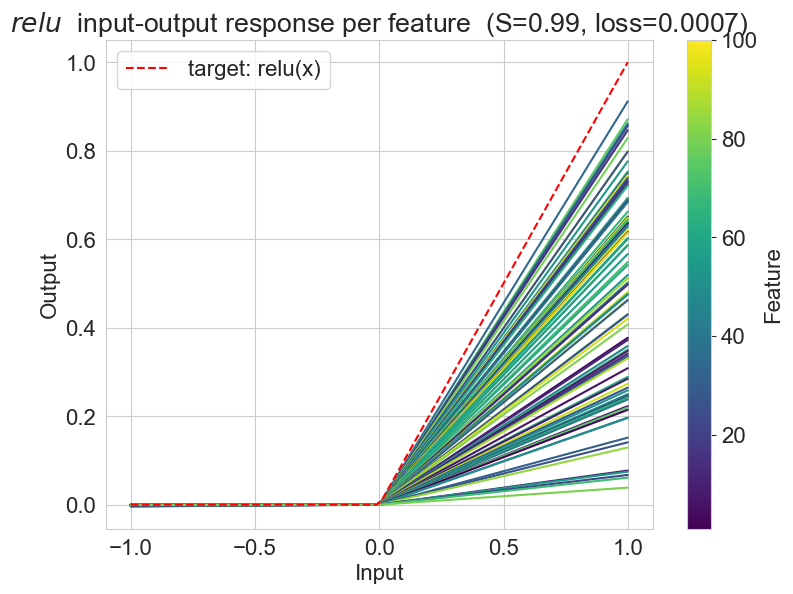

In [37]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(
    r"$\mathit{relu}$  " 
    + f"input-output response per feature  (S={feat_sparsity}, loss={losses[-1]:.4f})"
)
ax.legend()

#### weights

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, '$\\mathit{relu}$ feature weights per neuron')

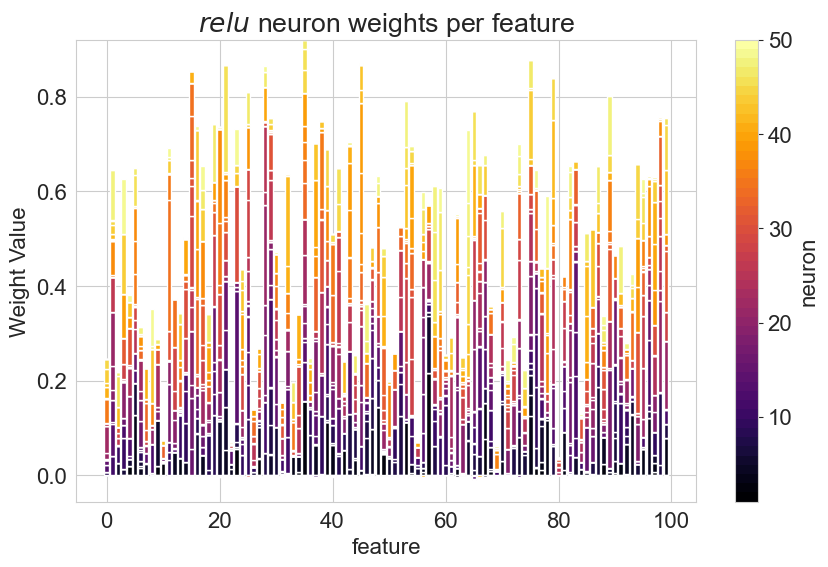

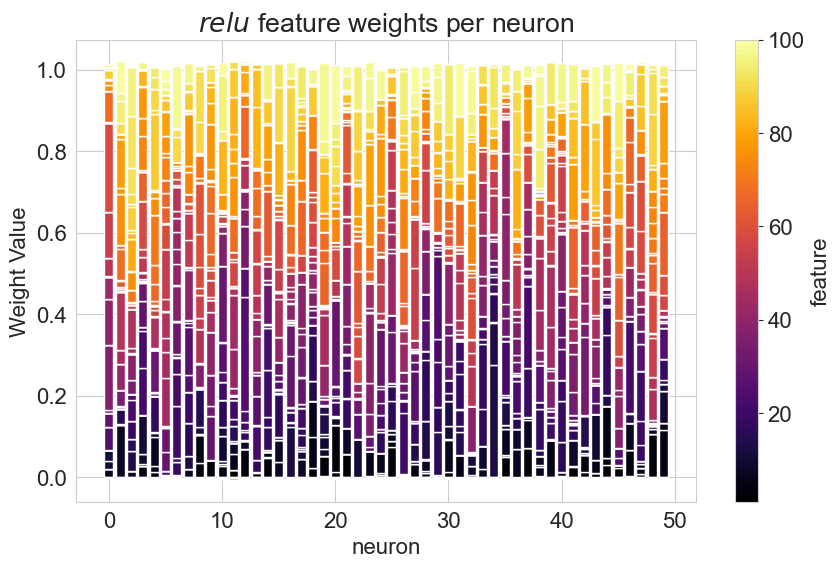

In [38]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(relu_cis.W1, relu_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title(r"$\mathit{relu}$ neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title(r"$\mathit{relu}$ feature weights per neuron")

Text(0.5, 1.0, 'Distribution of nonzero neuron weights per feature')

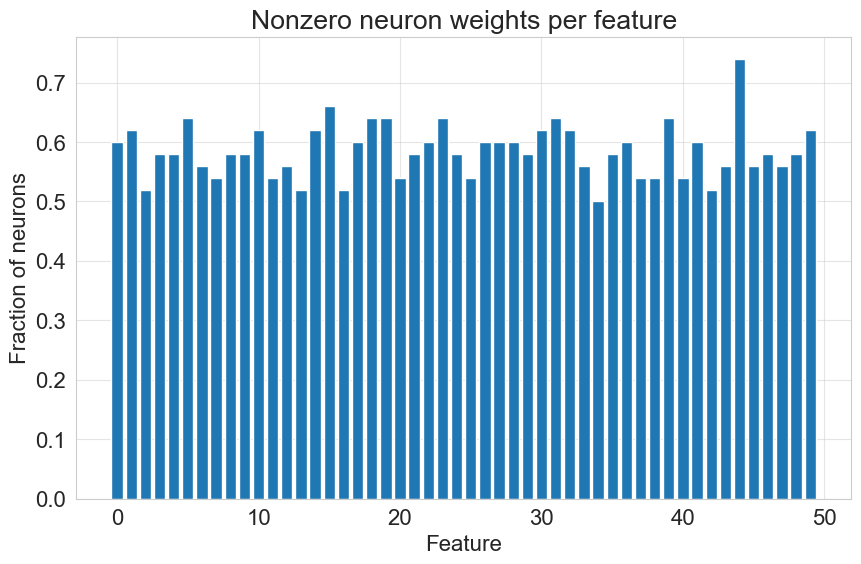

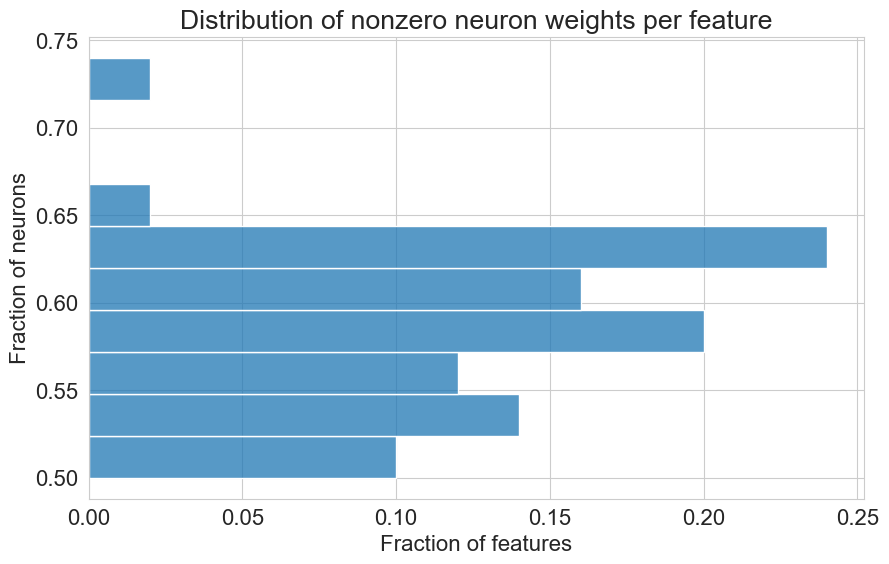

In [26]:
"""Plot nonzero neuron weights per feature."""

nonzero_counts = reduce(W, "neuron feature -> neuron", t.count_nonzero)
frac_nonzero = nonzero_counts / relu_cis.cfg.n_hidden
frac_nonzero = asnumpy(frac_nonzero)

# Plot nonzero_counts per feature
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(nonzero_counts)), frac_nonzero)
ax.set_xlabel("Feature")
ax.set_ylabel("Fraction of neurons")
ax.set_title("Nonzero neuron weights per feature")
ax.grid(True, alpha=0.5)

# Plot distribution of nonzero_counts
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=pd.DataFrame({"frac_nonzero": frac_nonzero}),
    y="frac_nonzero",
    binwidth=0.025,
    stat="probability",
    ax=ax
)
ax.set_xlabel("Fraction of features")
ax.set_ylabel("Fraction of neurons")
ax.set_title("Distribution of nonzero neuron weights per feature")

#### how many features are learned? or, what is loss per feature?

Text(0.5, 1.0, 'Loss per feature, for 1000 examples per feature')

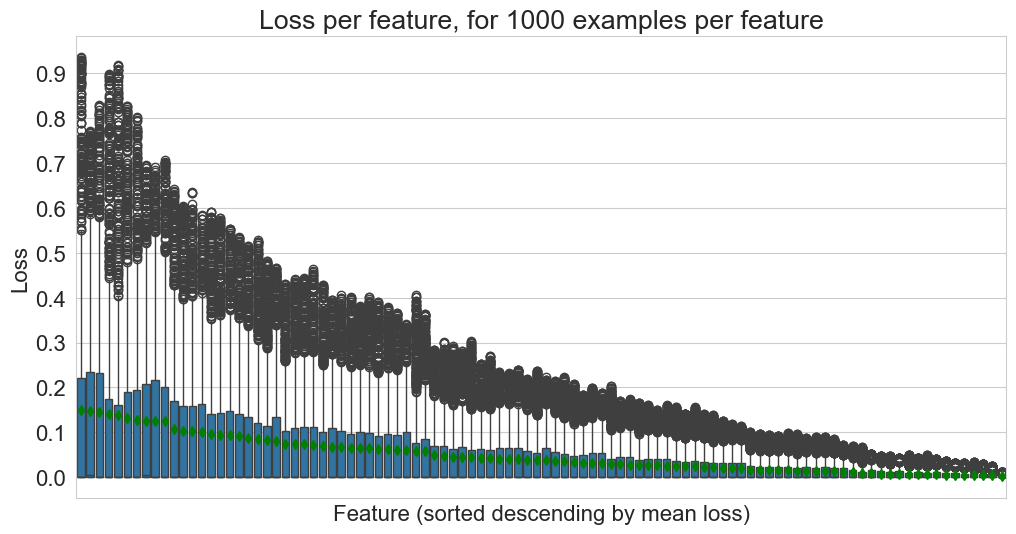

In [32]:
"""Box of loss per feature, ranked from highest mean loss to lowest."""

n_examples = 1000
losses = t.zeros((n_examples, relu_cis.cfg.n_feat), device=device)

# Activate only one feature at a time and calculate loss for that feature; loop for all features
for feat in range(relu_cis.cfg.n_feat):
    x = t.zeros(
        n_examples, relu_cis.cfg.n_instances, relu_cis.cfg.n_feat, device=device
    )
    # make only feat-th feature active
    x[:, :, feat] = rearrange((t.rand(n_examples) * 2 - 1), "n -> n 1")
    y_true = t.relu(x)
    y = relu_cis.forward(x)
    losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()

sorted_idxs = t.argsort(reduce(losses, "example feat -> feat", "mean"), descending=True)
losses = losses[:, sorted_idxs]
sorted_idxs = asnumpy(sorted_idxs)
df = pd.DataFrame(asnumpy(losses))
df_melted = df.melt(var_name="Feature", value_name="Loss")

fig, ax = plt.subplots(figsize=(12, 6))
meanprops = dict(marker="d", markerfacecolor="green", markeredgecolor="green", markersize=5)
sns.boxplot(data=df_melted, x="Feature", y="Loss", ax=ax, showmeans=True, meanprops=meanprops)

ax.set_xticks([], [])  # Hide x-axis labels if too many
ax.set_xlabel("Feature (sorted descending by mean loss)")
ax.set_ylabel("Loss")
ax.set_yticks(np.arange(0, 1, 0.1))
ax.set_title(f"Loss per feature, for {n_examples} examples per feature")

Text(0.5, 1.0, 'Distribution of mean loss per feature')

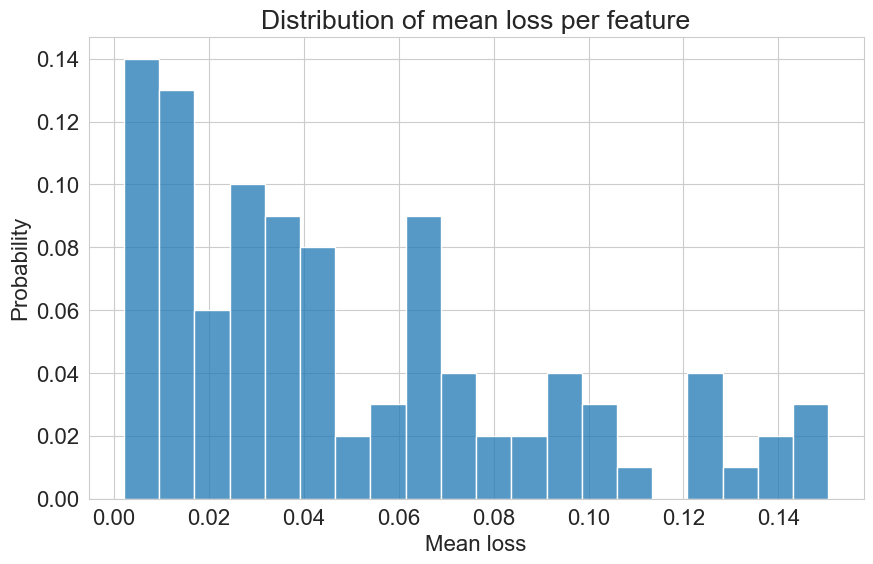

In [33]:
"""Distribution of mean loss per feature."""

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    asnumpy(reduce(losses, "example feat -> feat", "mean")), bins=20, stat="probability", ax=ax
)
ax.set_xlabel("Mean loss")
ax.set_title("Distribution of mean loss per feature")

#### loss and polysemanticity as a function of sparsity

1. polysemanticity (distribution of nonzero weights per feature)
  
2. distribution of loss per feature

In [40]:
"""Get polysemanticity and loss for set of sparsities."""

sparsities = np.round(np.linspace(0.0, 0.99, 10), 2)
batch_sz = 256
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    relu_cis = Cis(simple_relu_cfg, device=device).to(device)
    optimizer = t.optim.Adam(relu_cis.parameters())
    losses = train(
        relu_cis,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity and weight data
    W = einsum(
        relu_cis.W1, relu_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature"
    )
    W = asnumpy(threshold_matrix(W.squeeze(), threshold=0.001))
    
    # Calculate weight magnitudes and nonzero fractions
    weight_magnitudes = np.abs(W).sum(axis=0)
    nonzero_counts = np.count_nonzero(W, axis=0)
    frac_nonzero = nonzero_counts / relu_cis.cfg.n_hidden
    
    # Store polysemanticity and weight data for each feature
    for feat_idx in range(relu_cis.cfg.n_feat):
        poly_data.append(
            {
                "sparsity": s,
                "feature_idx": feat_idx,
                "frac_nonzero": frac_nonzero[feat_idx],
                "weight_magnitude": weight_magnitudes[feat_idx]
            }
        )

    # Calculate mean loss per feature over a set of examples
    n_examples = 100
    losses = t.zeros((n_examples, relu_cis.cfg.n_feat), device=device)
    with t.no_grad():
        for feat in range(relu_cis.cfg.n_feat):
            x = t.zeros(
                n_examples, 
                relu_cis.cfg.n_instances, 
                relu_cis.cfg.n_feat, 
                device=device
            )
            x[:, :, feat] = rearrange(t.linspace(-1, 1, n_examples, device=device), "n -> n 1")
            y_true = t.relu(x)
            y = relu_cis.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for feat_idx, val in enumerate(mean_losses):
        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "mean_loss": val})

Training over sparsities:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

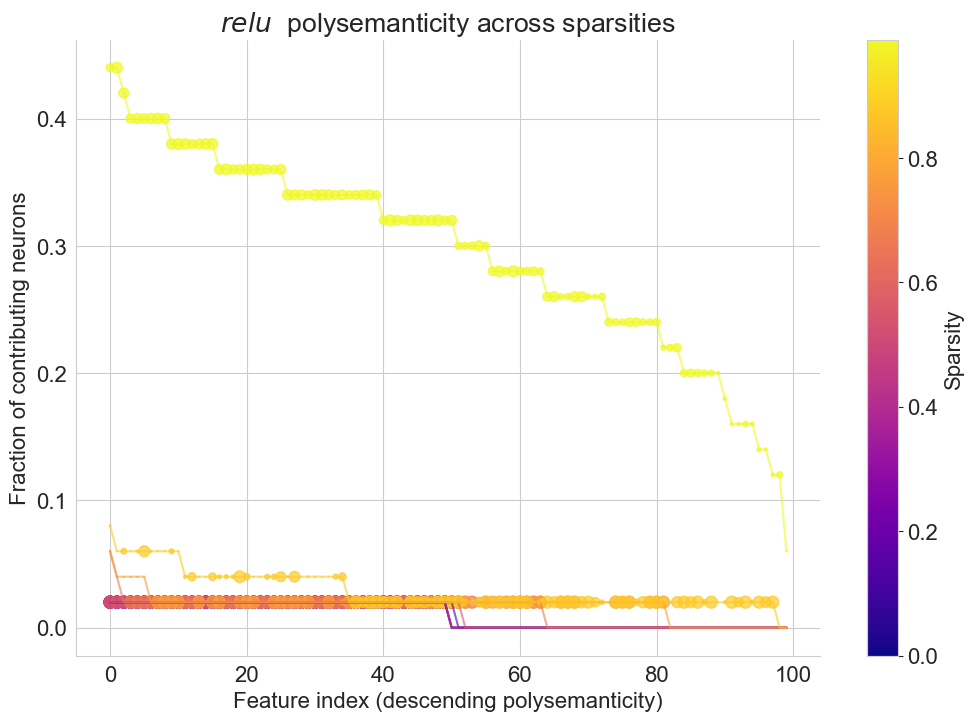

In [42]:
"""Plot polysemanticity across sparsities."""

# Create DataFrame
df_poly = pd.DataFrame(poly_data)

# Normalize weight magnitudes across all weights
df_poly["weight_magnitude_norm"] = (
    (df_poly["weight_magnitude"] - df_poly["weight_magnitude"].min()) 
    / (df_poly["weight_magnitude"].max() - df_poly["weight_magnitude"].min())
)

# Calculate feature ranks based on polysemanticity for each sparsity level
df_poly = df_poly.sort_values("feature_idx")  # ensure consistent initial order
for s in sparsities:
    mask = df_poly["sparsity"] == s
    # Get ranks for this sparsity level
    sparsity_data = df_poly[mask].copy()
    # Sort by frac_nonzero and create ranks
    sparsity_data = sparsity_data.sort_values("frac_nonzero", ascending=False)
    sparsity_data["feature_rank"] = range(len(sparsity_data))
    # Update the main dataframe
    df_poly.loc[mask, "feature_rank"] = sparsity_data["feature_rank"]

fig, ax = plt.subplots(figsize=(12, 8))

# Create plot using seaborn
sns.lineplot(
    data=df_poly,
    x="feature_rank",
    y="frac_nonzero",
    hue="sparsity",
    palette="plasma",
    alpha=0.6,
    ax=ax,
)

# Add scatter plots with sized markers
for sparsity in sparsities:
    mask = df_poly["sparsity"] == sparsity
    subset = df_poly[mask].sort_values("feature_rank")
    
    ax.scatter(
        subset["feature_rank"],
        subset["frac_nonzero"],
        s=subset["weight_magnitude_norm"] * 75,
        alpha=0.7,
        color=plt.cm.plasma(sparsity/max(sparsities)),
        label=f"Sparsity {sparsity:.2f}"
    )

# Customize the plot
ax.set_xlabel("Feature index (descending polysemanticity)")
ax.set_ylabel("Fraction of contributing neurons")
ax.set_title(r"$\mathit{relu}$  polysemanticity across sparsities")

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Handle legend (might want to remove since we have colorbar)
ax.get_legend().remove()

# plt.tight_layout()

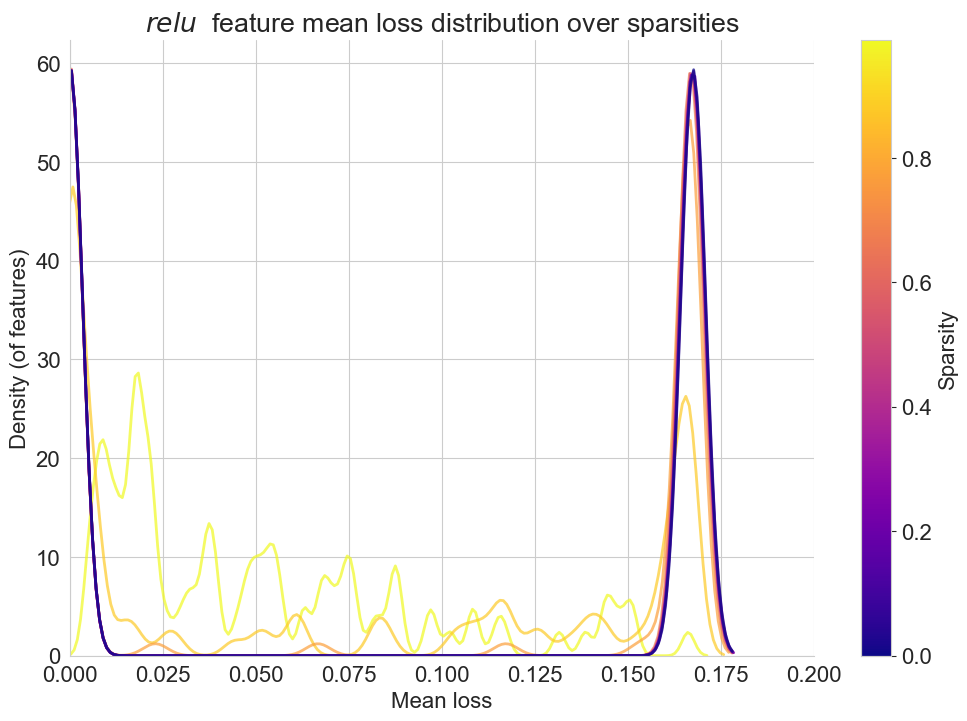

In [44]:
"""Plot feature mean loss distribution across sparsities."""

df_loss = pd.DataFrame(loss_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Create density plots using seaborn
sns.kdeplot(
    data=df_loss,
    x="mean_loss",
    hue="sparsity",
    palette="plasma",
    ax=ax,
    bw_adjust=0.1,  # Reduce bandwidth for less smoothing
    linewidth=2,
    alpha=0.7,
    common_norm=False  # Each curve normalized independently
)

# Customize the plot
ax.set_xlabel("Mean loss")
ax.set_ylabel("Density (of features)")
ax.set_title(r"$\mathit{relu}$  feature mean loss distribution over sparsities")
ax.set_xlim(0., 0.2)

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Remove legend since we have colorbar
ax.get_legend().remove()

# plt.tight_layout()

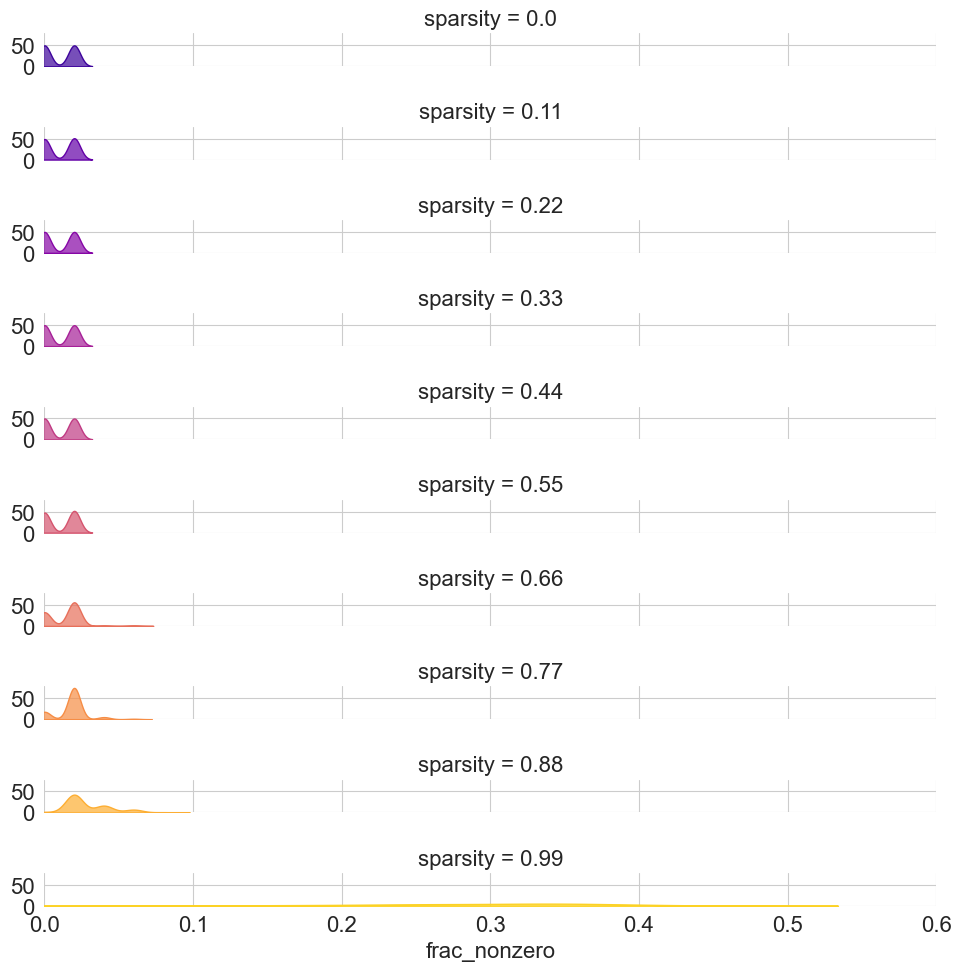

In [46]:
"""Could also potentially plot polysemanticity (and loss) per sparsity level as facetgrid
where each sparsity level has its own axis - but this doesn't look as good imo
"""

g = sns.FacetGrid(
    df_poly,
    row="sparsity",
    hue="sparsity",
    aspect=10,  # wide aspect so we can see the ridgeline shape
    height=1,  # each subplot’s height in inches
    palette="plasma",   
    sharex=True,        
    sharey=True
)

g.map(
    sns.kdeplot,
    "frac_nonzero",
    fill=True,
    alpha=0.7, 
)
g.set(ylabel=None)
g.set(xlim=(0, 0.6))
g.despine(left=True, bottom=True)


## *relu_onehot*

Target: 
$$
y = ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h
$$

Input (one-hot vector):

$$
x = \text{randint}(-1, 1) \\
$$ 

Loss (weighted mse):

$$
\text{WMSE} = \frac{1}{N} \sum_{i=1}^{N} w_i \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
\text{where} \\[2ex]
w_i =
\begin{cases}
10, & \text{if } y_{\text{true},i} = 1, \\
1, & \text{otherwise}.
\end{cases}
$$



### training

In [47]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    x = t.zeros(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device)
    active_positions = t.randint(
            0, model.cfg.n_feat, (batch_sz, model.cfg.n_instances), device=device
    )
    active_values = t.randint(0, 2, (batch_sz, model.cfg.n_instances), device=device) * 2.0 - 1
    
    # Create index tensors for vectorized assignment
    batch_idx = t.arange(batch_sz, device=device).view(-1, 1).expand(-1, model.cfg.n_instances)
    instance_idx = t.arange(model.cfg.n_instances, device=device).expand(batch_sz, -1)
    x[batch_idx, instance_idx, active_positions] = active_values
    
    return x, t.relu(x)

def loss_fn(y: Float[Tensor, "batch inst feat"], y_true: Float[Tensor, "batch inst feat"]) -> Float:
    active_weight, inactive_weight = 10, 1
    weights = t.where(y_true == 1, active_weight, inactive_weight)
    wmse = weights * (y - y_true) ** 2
    return reduce(wmse, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz)
        y = model.forward(x)
        loss = loss_fn(y, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [53]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

relu_onehot_cis_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

relu_onehot_cis = Cis(relu_onehot_cis_cfg, device=device).to(device)


batch_sz = 256
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(relu_onehot_cis.parameters())

losses = train(
    relu_onehot_cis,
    batch_sz,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.04728975147008896,
 0.004628343507647514,
 0.004478469491004944,
 0.004647082649171352,
 0.004869034979492426,
 0.0041213249787688255,
 0.004657336976379156,
 0.004648929461836815,
 0.004512019455432892,
 0.0049339644610881805,
 0.004313179291784763]

### viz

#### input-output response

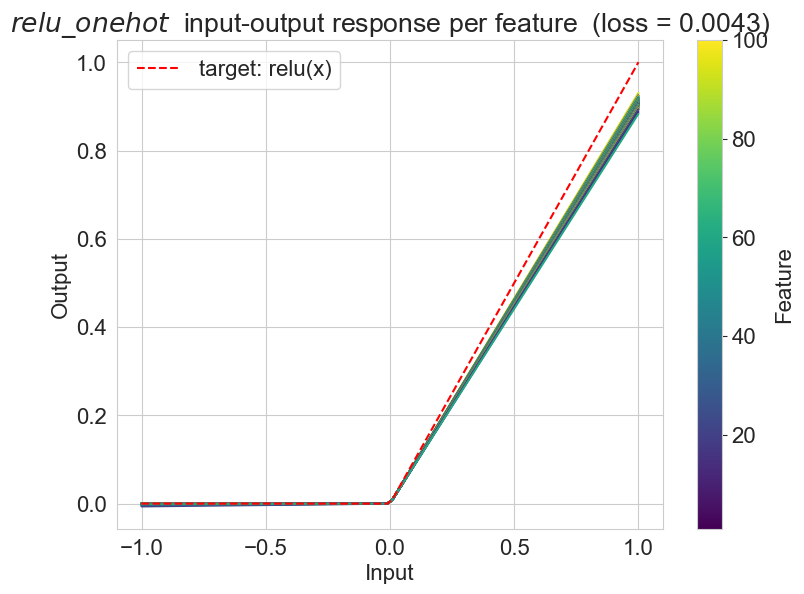

In [54]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_onehot_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(
    r"$\mathit{relu\_onehot}$  " 
    + f"input-output response per feature  (loss = {losses[-1]:.4f})"
)
ax.legend()

#### weights

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, '$\\mathit{relu\\_onehot}$  feature weights per neuron')

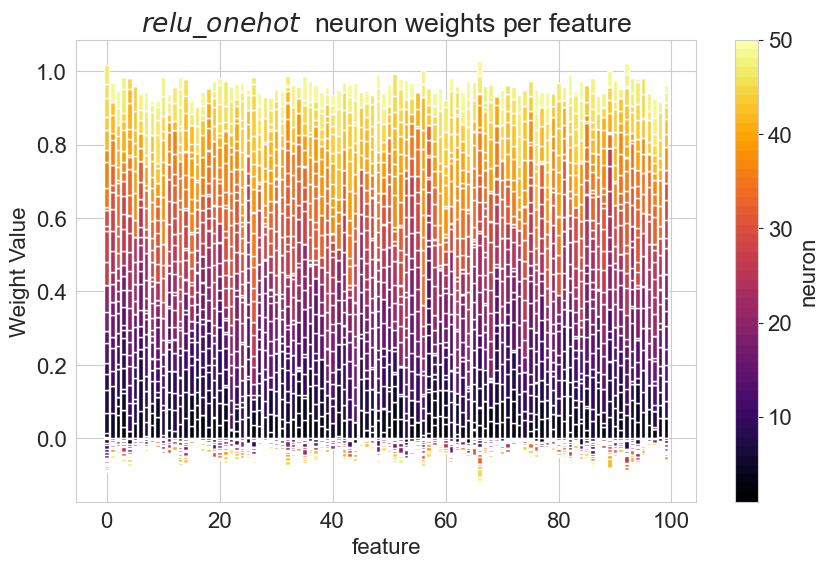

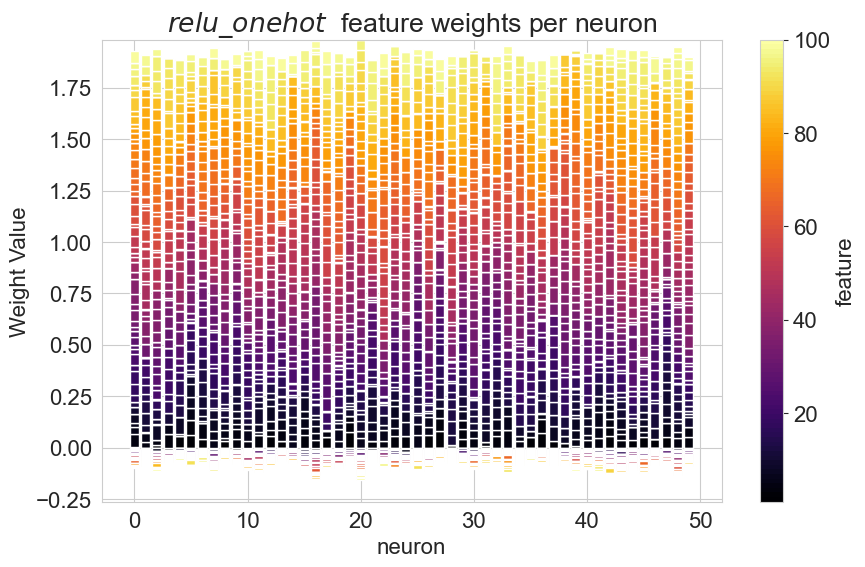

In [55]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(relu_onehot_cis.W1, relu_onehot_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title( r"$\mathit{relu\_onehot}$  neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title( r"$\mathit{relu\_onehot}$  feature weights per neuron")

#### loss and polysemanticity as a function of sparsity

In [57]:
"""Get polysemanticity and loss for set of sparsities."""

sparsities = np.round(np.linspace(0.0, 0.99, 10), 2)
batch_sz = 256
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    relu_onehot_cis = Cis(relu_onehot_cis_cfg, device=device).to(device)
    optimizer = t.optim.Adam(relu_onehot_cis.parameters())
    losses = train(
        relu_onehot_cis,
        batch_sz,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity and weight data
    W = einsum(
        relu_onehot_cis.W1, relu_onehot_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature"
    )
    W = asnumpy(threshold_matrix(W.squeeze(), threshold=0.001))
    
    # Calculate weight magnitudes and nonzero fractions
    weight_magnitudes = np.abs(W).sum(axis=0)
    nonzero_counts = np.count_nonzero(W, axis=0)
    frac_nonzero = nonzero_counts / relu_onehot_cis.cfg.n_hidden
    
    # Store polysemanticity and weight data for each feature
    for feat_idx in range(relu_onehot_cis.cfg.n_feat):
        poly_data.append(
            {
                "sparsity": s,
                "feature_idx": feat_idx,
                "frac_nonzero": frac_nonzero[feat_idx],
                "weight_magnitude": weight_magnitudes[feat_idx]
            }
        )

    # Calculate mean loss per feature over a set of examples
    n_examples = 100
    losses = t.zeros((n_examples, relu_onehot_cis.cfg.n_feat), device=device)
    with t.no_grad():
        for feat in range(relu_onehot_cis.cfg.n_feat):
            x = t.zeros(
                n_examples, 
                relu_onehot_cis.cfg.n_instances, 
                relu_onehot_cis.cfg.n_feat, 
                device=device
            )
            x[:, :, feat] = rearrange(t.linspace(-1, 1, n_examples, device=device), "n -> n 1")
            y_true = t.relu(x)
            y = relu_onehot_cis.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for feat_idx, val in enumerate(mean_losses):
        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "mean_loss": val})

Training over sparsities:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

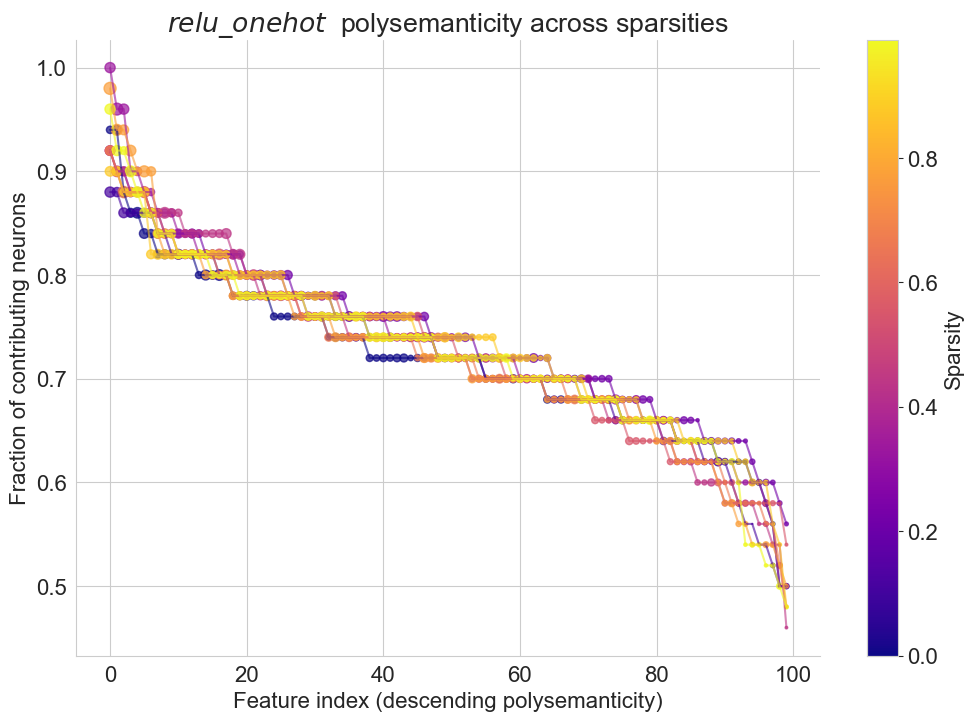

In [58]:
"""Plot polysemanticity across sparsities."""

# Create DataFrame
df_poly = pd.DataFrame(poly_data)

# Normalize weight magnitudes across all weights
df_poly["weight_magnitude_norm"] = (
    (df_poly["weight_magnitude"] - df_poly["weight_magnitude"].min()) 
    / (df_poly["weight_magnitude"].max() - df_poly["weight_magnitude"].min())
)

# Calculate feature ranks based on polysemanticity for each sparsity level
df_poly = df_poly.sort_values("feature_idx")  # ensure consistent initial order
for s in sparsities:
    mask = df_poly["sparsity"] == s
    # Get ranks for this sparsity level
    sparsity_data = df_poly[mask].copy()
    # Sort by frac_nonzero and create ranks
    sparsity_data = sparsity_data.sort_values("frac_nonzero", ascending=False)
    sparsity_data["feature_rank"] = range(len(sparsity_data))
    # Update the main dataframe
    df_poly.loc[mask, "feature_rank"] = sparsity_data["feature_rank"]

fig, ax = plt.subplots(figsize=(12, 8))

# Create plot using seaborn
sns.lineplot(
    data=df_poly,
    x="feature_rank",
    y="frac_nonzero",
    hue="sparsity",
    palette="plasma",
    alpha=0.6,
    ax=ax,
)

# Add scatter plots with sized markers
for sparsity in sparsities:
    mask = df_poly["sparsity"] == sparsity
    subset = df_poly[mask].sort_values("feature_rank")
    
    ax.scatter(
        subset["feature_rank"],
        subset["frac_nonzero"],
        s=subset["weight_magnitude_norm"] * 75,
        alpha=0.7,
        color=plt.cm.plasma(sparsity/max(sparsities)),
        label=f"Sparsity {sparsity:.2f}"
    )

# Customize the plot
ax.set_xlabel("Feature index (descending polysemanticity)")
ax.set_ylabel("Fraction of contributing neurons")
ax.set_title(r"$\mathit{relu\_onehot}$  polysemanticity across sparsities")

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Handle legend (might want to remove since we have colorbar)
ax.get_legend().remove()

# plt.tight_layout()

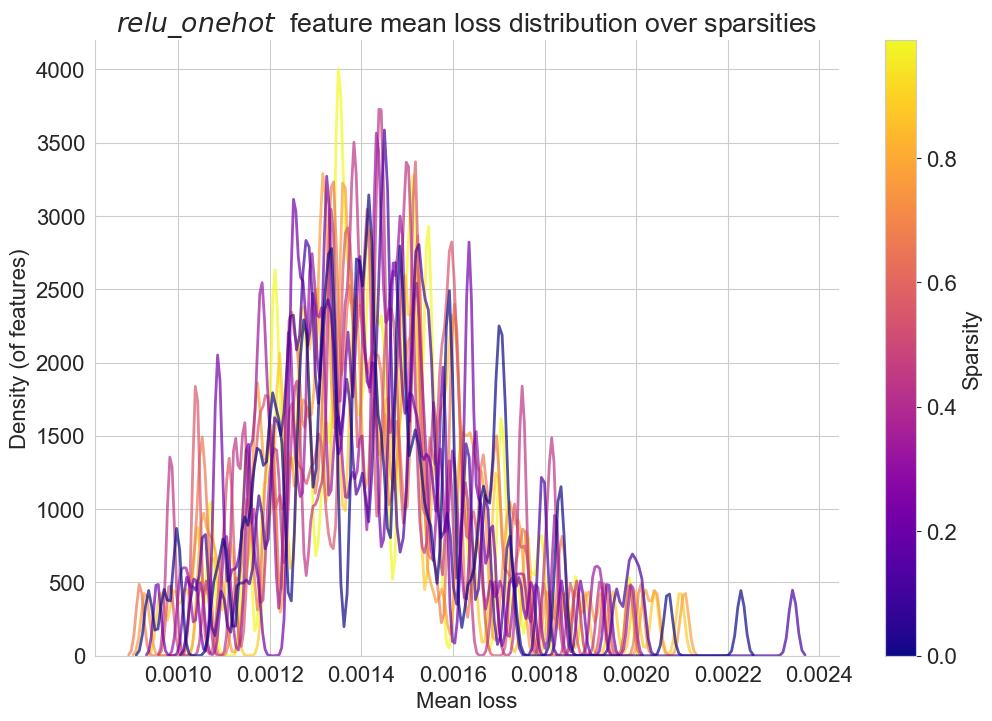

In [59]:
"""Plot feature mean loss distribution across sparsities."""

df_loss = pd.DataFrame(loss_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Create density plots using seaborn
sns.kdeplot(
    data=df_loss,
    x="mean_loss",
    hue="sparsity",
    palette="plasma",
    ax=ax,
    bw_adjust=0.1,  # Reduce bandwidth for less smoothing
    linewidth=2,
    alpha=0.7,
    common_norm=False  # Each curve normalized independently
)

# Customize the plot
ax.set_xlabel("Mean loss")
ax.set_ylabel("Density (of features)")
ax.set_title(r"$\mathit{relu\_onehot}$  feature mean loss distribution over sparsities")
# ax.set_xlim(0., 0.2)

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Remove legend since we have colorbar
ax.get_legend().remove()

# plt.tight_layout()

## *reluPlusX_res_noEmbed*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h + x
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

### training

In [60]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [61]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)

reluPlusX_res_noEmbed_cis = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(reluPlusX_res_noEmbed_cis.parameters())

losses = train(
    reluPlusX_res_noEmbed_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.0018670830177143216,
 0.0008733125287108123,
 0.0011212435783818364,
 0.0012039793655276299,
 0.0008082141866907477,
 0.000859147752635181,
 0.0009426031028851867,
 0.0008009129669517279,
 0.0009581524063833058,
 0.0009997274028137326,
 0.0008524861186742783]

### viz

#### input-output response

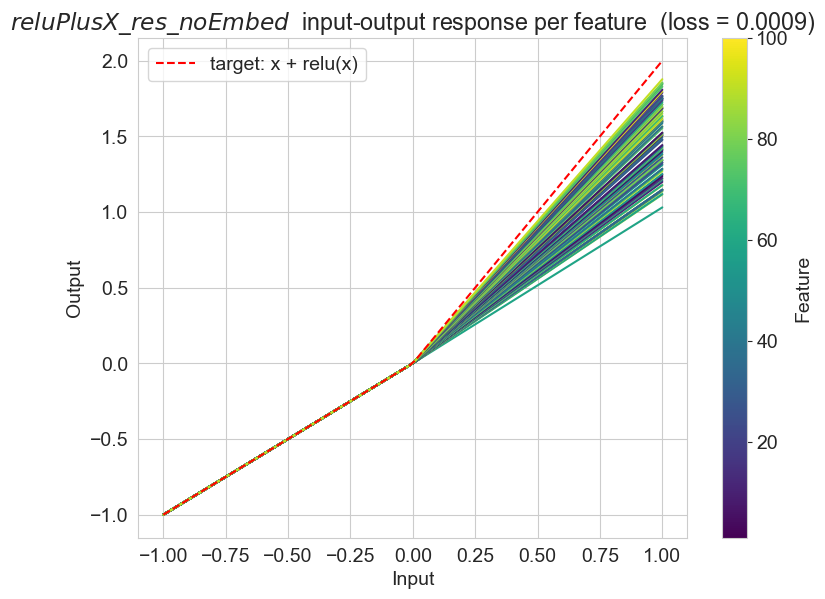

In [ ]:
"""Calculate and plot input-output response."""

plt.rcParams.update({"font.size": 14})

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_noEmbed_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(
    r"$\mathit{reluPlusX\_res\_noEmbed}$  " 
    + f"input-output response per feature  (loss = {losses[-1]:.4f})"
)
ax.legend()

#### weights

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, '$\\mathit{reluPlusX\\_res\\_noEmbed}$ feature weights per neuron')

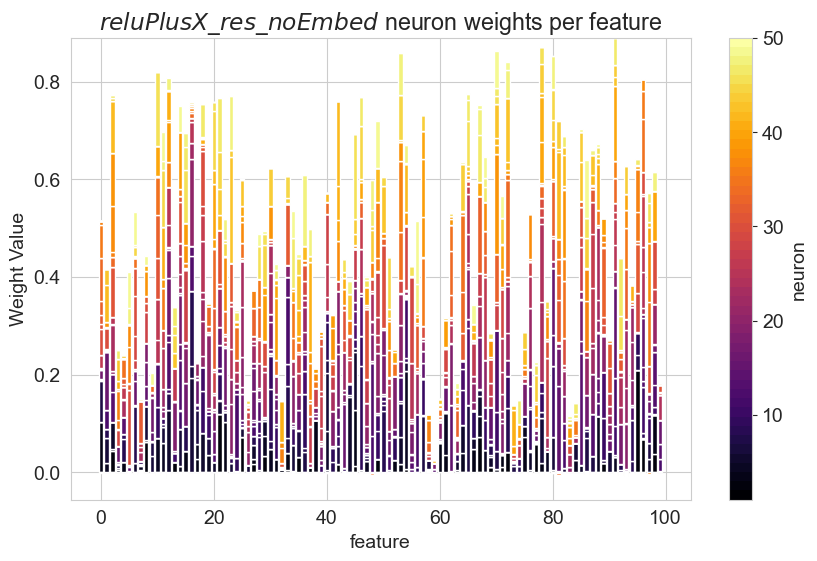

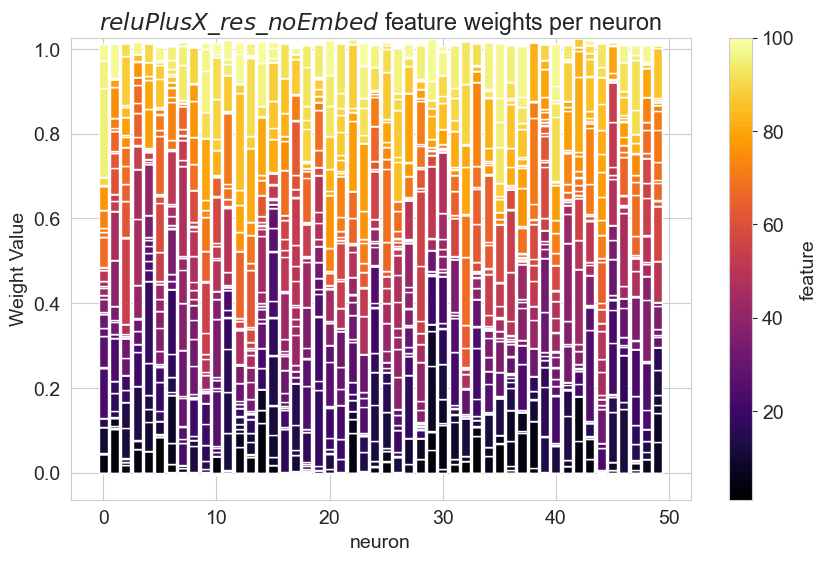

In [66]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(
    reluPlusX_res_noEmbed_cis.W1, 
    reluPlusX_res_noEmbed_cis.W2, 
    "inst neuron feature, inst feature neuron-> neuron feature"
)
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title(r"$\mathit{reluPlusX\_res\_noEmbed}$ neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title(r"$\mathit{reluPlusX\_res\_noEmbed}$ feature weights per neuron")

#### loss and polysemanticity as a function of sparsity

In [71]:
"""Get polysemanticity and loss for set of sparsities."""

sparsities = np.round(np.linspace(0.0, 0.99, 10), 2)
batch_sz = 256
feat_importance = 1
n_steps = 10000
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    reluPlusX_res_noEmbed_cis = Cis(simple_relu_cfg, device=device).to(device)
    optimizer = t.optim.Adam(reluPlusX_res_noEmbed_cis.parameters())
    losses = train(
        reluPlusX_res_noEmbed_cis,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity and weight data
    W = einsum(
        reluPlusX_res_noEmbed_cis.W1,
        reluPlusX_res_noEmbed_cis.W2,
        "inst neuron feature, inst feature neuron-> neuron feature"
    )
    W = asnumpy(threshold_matrix(W.squeeze(), threshold=0.001))
    
    # Calculate weight magnitudes and nonzero fractions
    weight_magnitudes = np.abs(W).sum(axis=0)
    nonzero_counts = np.count_nonzero(W, axis=0)
    frac_nonzero = nonzero_counts / reluPlusX_res_noEmbed_cis.cfg.n_hidden
    
    # Store polysemanticity and weight data for each feature
    for feat_idx in range(reluPlusX_res_noEmbed_cis.cfg.n_feat):
        poly_data.append(
            {
                "sparsity": s,
                "feature_idx": feat_idx,
                "frac_nonzero": frac_nonzero[feat_idx],
                "weight_magnitude": weight_magnitudes[feat_idx]
            }
        )

    # Calculate mean loss per feature over a set of examples
    n_examples = 100
    losses = t.zeros((n_examples, reluPlusX_res_noEmbed_cis.cfg.n_feat), device=device)
    with t.no_grad():
        for feat in range(reluPlusX_res_noEmbed_cis.cfg.n_feat):
            x = t.zeros(
                n_examples, 
                reluPlusX_res_noEmbed_cis.cfg.n_instances, 
                reluPlusX_res_noEmbed_cis.cfg.n_feat, 
                device=device
            )
            x[:, :, feat] = rearrange(t.linspace(-1, 1, n_examples, device=device), "n -> n 1")
            y_true = t.relu(x)
            y = reluPlusX_res_noEmbed_cis.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for feat_idx, val in enumerate(mean_losses):
        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "mean_loss": val})

Training over sparsities:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

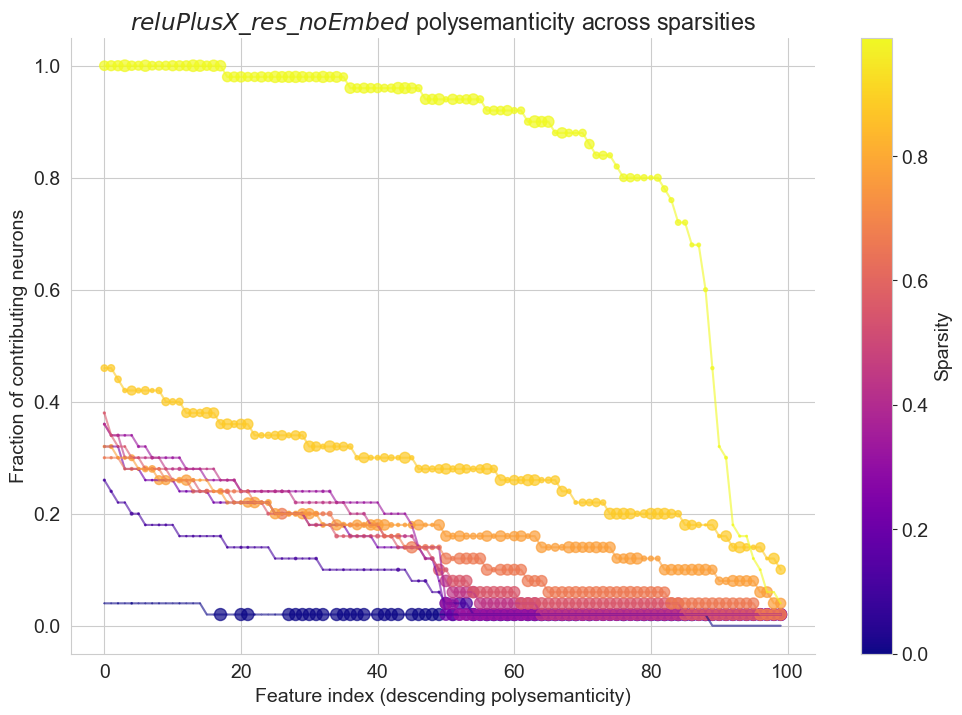

In [72]:
"""Plot polysemanticity across sparsities."""

# Create DataFrame
df_poly = pd.DataFrame(poly_data)

# Normalize weight magnitudes across all weights
df_poly["weight_magnitude_norm"] = (
    (df_poly["weight_magnitude"] - df_poly["weight_magnitude"].min()) 
    / (df_poly["weight_magnitude"].max() - df_poly["weight_magnitude"].min())
)

# Calculate feature ranks based on polysemanticity for each sparsity level
df_poly = df_poly.sort_values("feature_idx")  # ensure consistent initial order
for s in sparsities:
    mask = df_poly["sparsity"] == s
    # Get ranks for this sparsity level
    sparsity_data = df_poly[mask].copy()
    # Sort by frac_nonzero and create ranks
    sparsity_data = sparsity_data.sort_values("frac_nonzero", ascending=False)
    sparsity_data["feature_rank"] = range(len(sparsity_data))
    # Update the main dataframe
    df_poly.loc[mask, "feature_rank"] = sparsity_data["feature_rank"]

fig, ax = plt.subplots(figsize=(12, 8))

# Create plot using seaborn
sns.lineplot(
    data=df_poly,
    x="feature_rank",
    y="frac_nonzero",
    hue="sparsity",
    palette="plasma",
    alpha=0.6,
    ax=ax,
)

# Add scatter plots with sized markers
for sparsity in sparsities:
    mask = df_poly["sparsity"] == sparsity
    subset = df_poly[mask].sort_values("feature_rank")
    
    ax.scatter(
        subset["feature_rank"],
        subset["frac_nonzero"],
        s=subset["weight_magnitude_norm"] * 75,
        alpha=0.7,
        color=plt.cm.plasma(sparsity/max(sparsities)),
        label=f"Sparsity {sparsity:.2f}"
    )

# Customize the plot
ax.set_xlabel("Feature index (descending polysemanticity)")
ax.set_ylabel("Fraction of contributing neurons")
ax.set_title(r"$\mathit{reluPlusX\_res\_noEmbed}$ polysemanticity across sparsities")

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Handle legend (might want to remove since we have colorbar)
ax.get_legend().remove()

# plt.tight_layout()

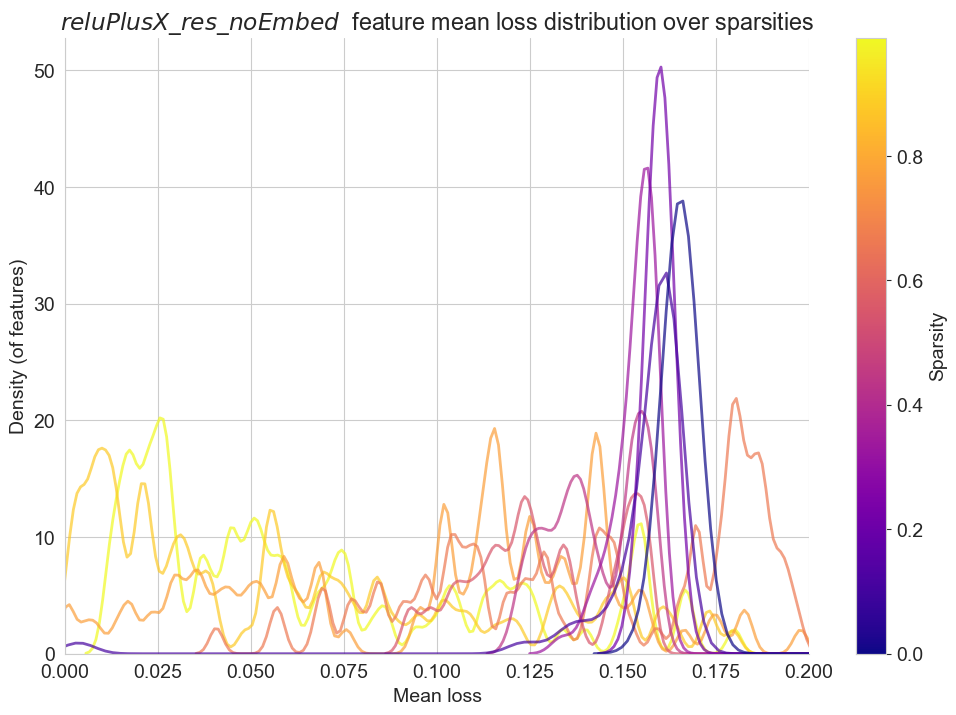

In [74]:
"""Plot feature mean loss distribution across sparsities."""

df_loss = pd.DataFrame(loss_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Create density plots using seaborn
sns.kdeplot(
    data=df_loss,
    x="mean_loss",
    hue="sparsity",
    palette="plasma",
    ax=ax,
    bw_adjust=0.1,  # Reduce bandwidth for less smoothing
    linewidth=2,
    alpha=0.7,
    common_norm=False  # Each curve normalized independently
)

# Customize the plot
ax.set_xlabel("Mean loss")
ax.set_ylabel("Density (of features)")
ax.set_title(r"$\mathit{reluPlusX\_res\_noEmbed}$  feature mean loss distribution over sparsities")
ax.set_xlim(0., 0.2)

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Remove legend since we have colorbar
ax.get_legend().remove()

# plt.tight_layout()

## *reluPlusX_res_embed*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
e = W_e x \\
h = ReLU(W_1 e) \\
u = W_2 h + x
y' = W_u u
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

### training

In [4]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [ ]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters(), lr=5e-4)

losses = train(
    reluPlusX_res_embed_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.0023548302706331015,
 0.0008205948979593813,
 0.0007854931754991412,
 0.0007810425013303757,
 0.0006983413477428257,
 0.0006173643632791936,
 0.000670682406052947,
 0.0006148580578155816,
 0.0007063809898681939,
 0.0006883356254547834,
 0.0006091359537094831]

### viz

#### input-output response

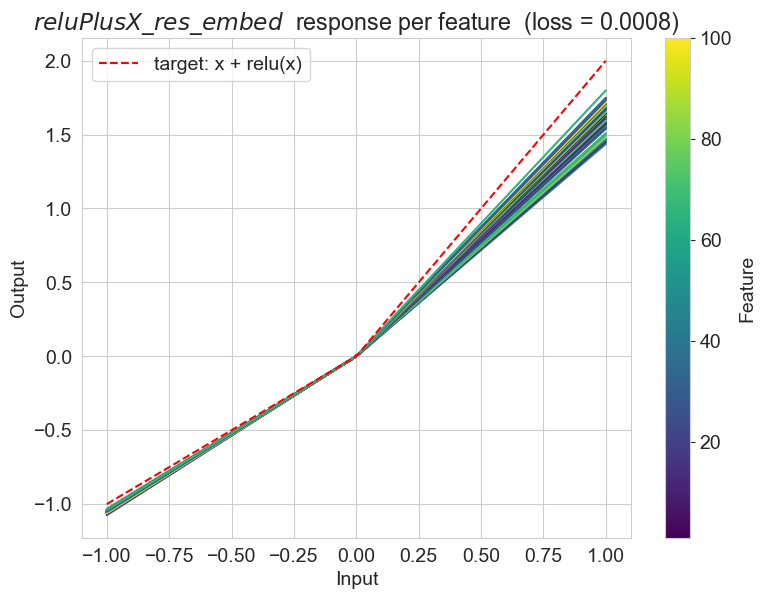

In [84]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_embed_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(
    r"$\mathit{reluPlusX\_res\_embed}$  "
    + f"response per feature  (loss = {losses[-1]:.4f})")
ax.legend()

#### weights

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, '$\\mathit{reluPlusX\\_res\\_embed}$  feature weights per neuron')

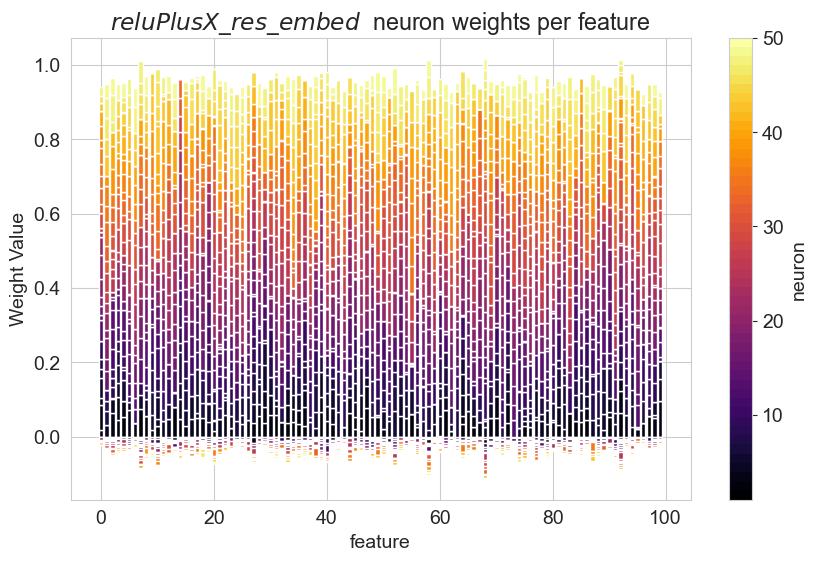

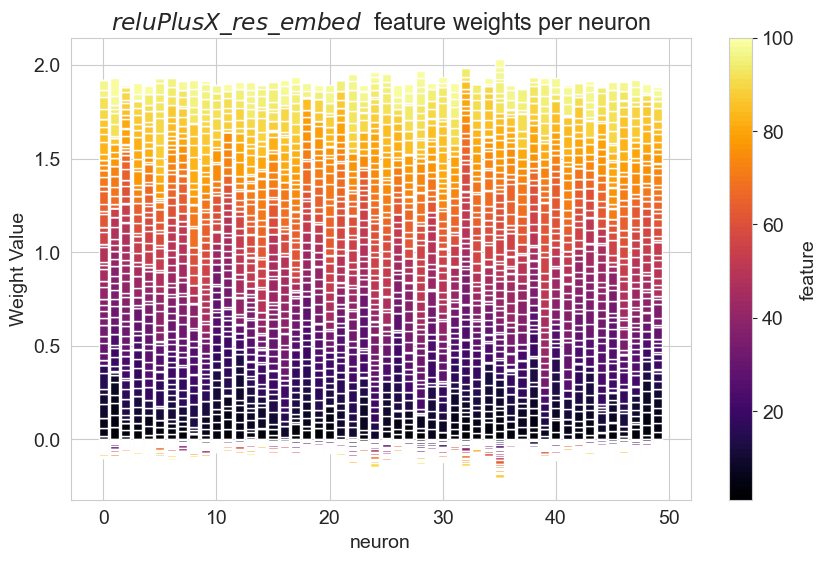

In [85]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(relu_onehot_cis.W1, relu_onehot_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title(r"$\mathit{reluPlusX\_res\_embed}$  neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title(r"$\mathit{reluPlusX\_res\_embed}$  feature weights per neuron")

#### loss and polysemanticity as a function of sparsity

In [6]:
"""Get polysemanticity and loss for set of sparsities."""

sparsities = np.round(np.linspace(0.0, 0.99, 10), 2)
batch_sz = 256
feat_importance = 1
n_steps = 10000
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model
    reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device).to(device)
    optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters())
    losses = train(
        reluPlusX_res_embed_cis,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity and weight data
    W = einsum(
        reluPlusX_res_embed_cis.W1,
        reluPlusX_res_embed_cis.W2,
        "inst neuron feature, inst feature neuron-> neuron feature"
    )
    W = asnumpy(threshold_matrix(W.squeeze(), threshold=0.001))
    
    # Calculate weight magnitudes and nonzero fractions
    weight_magnitudes = np.abs(W).sum(axis=0)
    nonzero_counts = np.count_nonzero(W, axis=0)
    frac_nonzero = nonzero_counts / reluPlusX_res_embed_cis.cfg.n_hidden
    
    # Store polysemanticity and weight data for each feature
    for feat_idx in range(reluPlusX_res_embed_cis.cfg.n_feat):
        poly_data.append(
            {
                "sparsity": s,
                "feature_idx": feat_idx,
                "frac_nonzero": frac_nonzero[feat_idx],
                "weight_magnitude": weight_magnitudes[feat_idx]
            }
        )

    # Calculate mean loss per feature over a set of examples
    n_examples = 100
    losses = t.zeros((n_examples, reluPlusX_res_embed_cis.cfg.n_feat), device=device)
    with t.no_grad():
        for feat in range(reluPlusX_res_embed_cis.cfg.n_feat):
            x = t.zeros(
                n_examples, 
                reluPlusX_res_embed_cis.cfg.n_instances, 
                reluPlusX_res_embed_cis.cfg.n_feat, 
                device=device
            )
            x[:, :, feat] = rearrange(t.linspace(-1, 1, n_examples, device=device), "n -> n 1")
            y_true = t.relu(x)
            y = reluPlusX_res_embed_cis.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for feat_idx, val in enumerate(mean_losses):
        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "mean_loss": val})

Training over sparsities:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

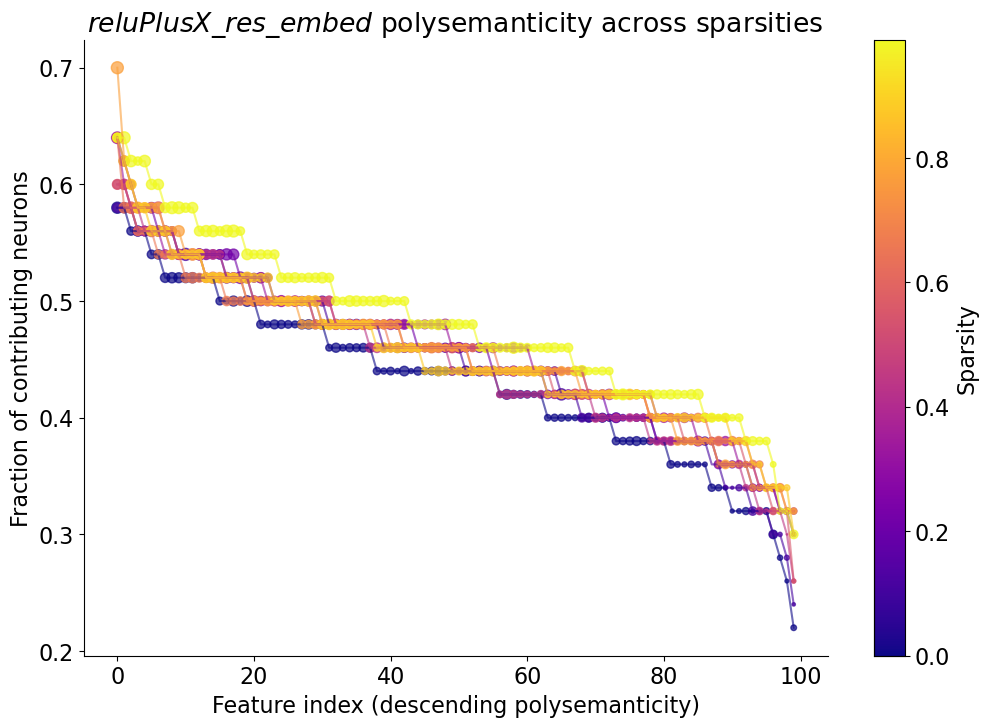

In [7]:
"""Plot polysemanticity across sparsities."""

# Create DataFrame
df_poly = pd.DataFrame(poly_data)

# Normalize weight magnitudes across all weights
df_poly["weight_magnitude_norm"] = (
    (df_poly["weight_magnitude"] - df_poly["weight_magnitude"].min()) 
    / (df_poly["weight_magnitude"].max() - df_poly["weight_magnitude"].min())
)

# Calculate feature ranks based on polysemanticity for each sparsity level
df_poly = df_poly.sort_values("feature_idx")  # ensure consistent initial order
for s in sparsities:
    mask = df_poly["sparsity"] == s
    # Get ranks for this sparsity level
    sparsity_data = df_poly[mask].copy()
    # Sort by frac_nonzero and create ranks
    sparsity_data = sparsity_data.sort_values("frac_nonzero", ascending=False)
    sparsity_data["feature_rank"] = range(len(sparsity_data))
    # Update the main dataframe
    df_poly.loc[mask, "feature_rank"] = sparsity_data["feature_rank"]

fig, ax = plt.subplots(figsize=(12, 8))

# Create plot using seaborn
sns.lineplot(
    data=df_poly,
    x="feature_rank",
    y="frac_nonzero",
    hue="sparsity",
    palette="plasma",
    alpha=0.6,
    ax=ax,
)

# Add scatter plots with sized markers
for sparsity in sparsities:
    mask = df_poly["sparsity"] == sparsity
    subset = df_poly[mask].sort_values("feature_rank")
    
    ax.scatter(
        subset["feature_rank"],
        subset["frac_nonzero"],
        s=subset["weight_magnitude_norm"] * 75,
        alpha=0.7,
        color=plt.cm.plasma(sparsity/max(sparsities)),
        label=f"Sparsity {sparsity:.2f}"
    )

# Customize the plot
ax.set_xlabel("Feature index (descending polysemanticity)")
ax.set_ylabel("Fraction of contributing neurons")
ax.set_title(r"$\mathit{reluPlusX\_res\_embed}$ polysemanticity across sparsities")

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Handle legend (might want to remove since we have colorbar)
ax.get_legend().remove()

# plt.tight_layout()

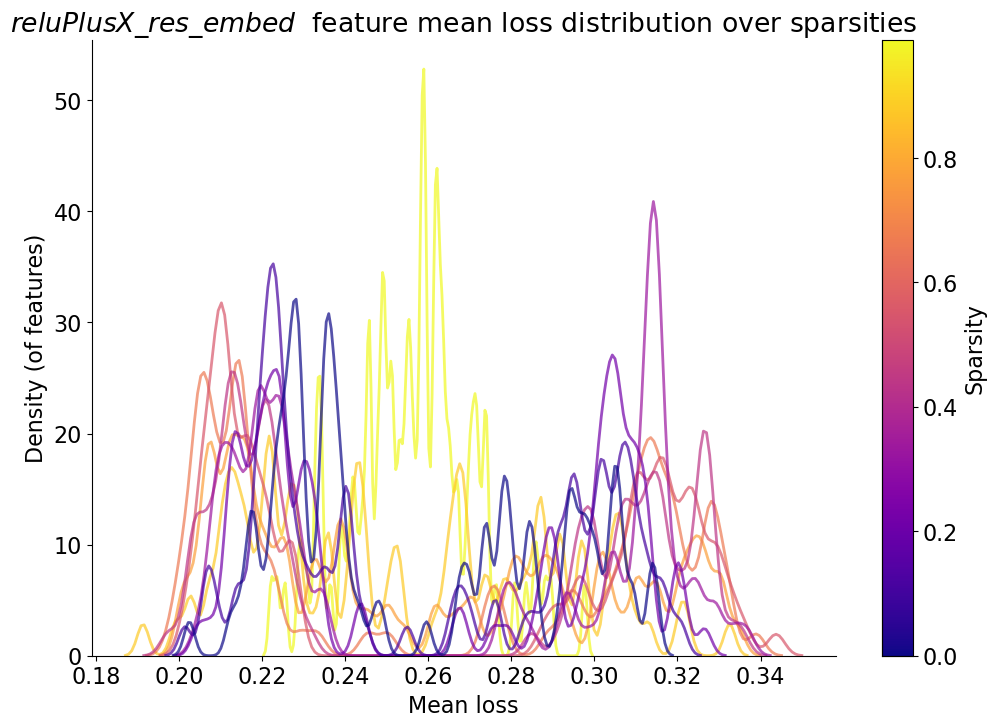

In [9]:
"""Plot feature mean loss distribution across sparsities."""

df_loss = pd.DataFrame(loss_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Create density plots using seaborn
sns.kdeplot(
    data=df_loss,
    x="mean_loss",
    hue="sparsity",
    palette="plasma",
    ax=ax,
    bw_adjust=0.1,  # Reduce bandwidth for less smoothing
    linewidth=2,
    alpha=0.7,
    common_norm=False  # Each curve normalized independently
)

# Customize the plot
ax.set_xlabel("Mean loss")
ax.set_ylabel("Density (of features)")
ax.set_title(r"$\mathit{reluPlusX\_res\_embed}$  feature mean loss distribution over sparsities")
# ax.set_xlim(0., 0.2)

# Add colorbar
norm = plt.Normalize(vmin=min(sparsities), vmax=max(sparsities))
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sparsity")

# Use seaborn style
sns.despine()

# Remove legend since we have colorbar
ax.get_legend().remove()

# plt.tight_layout()

## tms-cis

. . .

### training

In [5]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.abs(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [ ]:
"""Create and train model."""

layer_act_fns = [t.relu, t.relu]

abs_cfg = CisConfig(
    n_instances=1,
    n_feat=50,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=0.0,
    skip_cnx=False,
    We_and_Wu=False,
)

abs_cis = Cis(abs_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(abs_cis.parameters(), lr=5e-4)

losses = train(
    abs_cis,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_bmm)